In [1]:
# Train a kNN classifier (k=5) on the Iris dataset
# - Uses a Pipeline with StandardScaler + KNeighborsClassifier (k=5).
# - Creates a stratified train/test split (30% test) for reproducible evaluation.
# - At the end we print basic train/test accuracy to confirm training worked.

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load Iris
iris = load_iris()
X = iris.data          # 4 features
y = iris.target        # labels 0,1,2
feature_names = iris.feature_names
target_names = iris.target_names

# Stratified split (keeps class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Build pipeline: scaling + kNN (k=5)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Train
pipe.fit(X_train, y_train)

# Quick accuracy checks
train_acc = accuracy_score(y_train, pipe.predict(X_train))
test_acc  = accuracy_score(y_test,  pipe.predict(X_test))
print(f"Train accuracy (k=5): {train_acc:.4f}")
print(f"Test  accuracy (k=5): {test_acc:.4f}")


Train accuracy (k=5): 0.9810
Test  accuracy (k=5): 0.9111


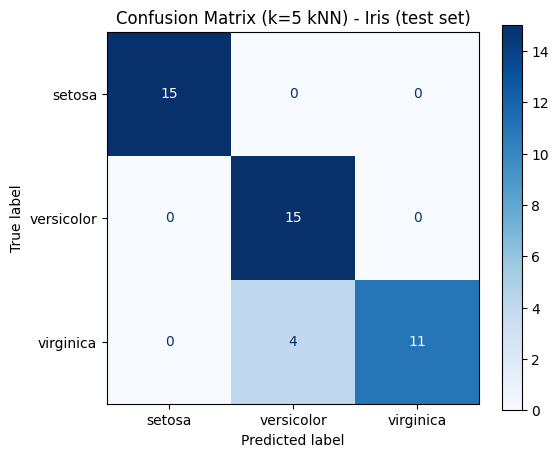

Confusion matrix (rows=true, cols=predicted):
[[15  0  0]
 [ 0 15  0]
 [ 0  4 11]]


In [2]:
# Compute and display the confusion matrix
# - Uses sklearn.metrics.confusion_matrix and ConfusionMatrixDisplay for a nice plot.
# - Shows absolute counts. If desired, you can normalize it instead.

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = pipe.predict(X_test)

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

# Plot
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
ax.set_title("Confusion Matrix (k=5 kNN) - Iris (test set)")
plt.show()

# Print the raw matrix for reference
print("Confusion matrix (rows=true, cols=predicted):")
print(cm)


In [3]:
# Compute accuracy, precision, recall, F1 using classification_report
# - classification_report reports per-class precision/recall/F1 and macro/weighted averages.
# - We print the report and also show overall accuracy.

from sklearn.metrics import classification_report

print("Classification report (test set):\n")
print(classification_report(y_test, y_pred, target_names=target_names))

# Also print accuracy explicitly (already shown in Cell 1)
from sklearn.metrics import accuracy_score
print(f"Overall accuracy (test): {accuracy_score(y_test, y_pred):.4f}")


Classification report (test set):

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45

Overall accuracy (test): 0.9111


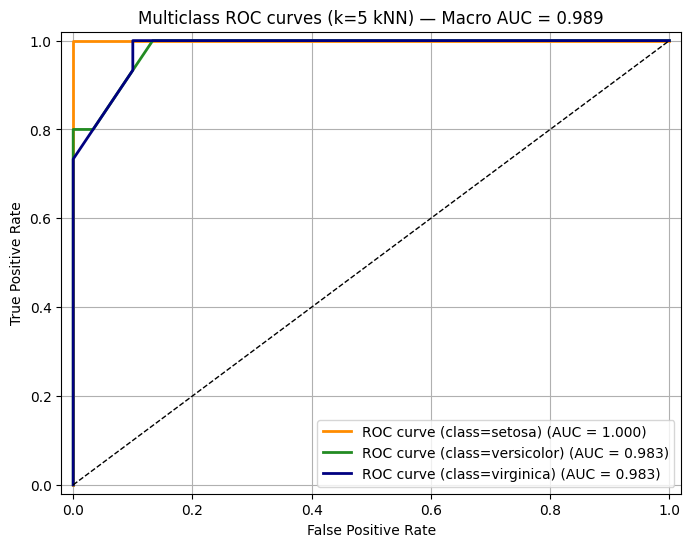

AUC for class setosa    : 1.0000
AUC for class versicolor: 0.9833
AUC for class virginica : 0.9833
Macro-averaged AUC: 0.9889
roc_auc_score (macro): 0.9888888888888889


In [5]:
#  Plot the ROC curve(s) and compute AUC (multiclass, one-vs-rest)
# - For multiclass ROC we binarize the labels (one-vs-rest) and plot an ROC for each class.
# - We compute & display per-class AUC and macro-averaged AUC (mean of class AUCs).
# - We use the classifier's predict_proba output as scores (kNN supports predict_proba).

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Binarize the test labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities for each class
# (Pipeline applies scaling then knn.predict_proba)
y_score = pipe.predict_proba(X_test)  # shape (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average AUC (average of per-class AUCs)
macro_auc = np.mean([roc_auc[i] for i in range(n_classes)])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'forestgreen', 'navy']
for i, color in enumerate(colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve (class={target_names[i]}) (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # chance line
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multiclass ROC curves (k=5 kNN) — Macro AUC = {macro_auc:.3f}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print numeric AUC values
for i in range(n_classes):
    print(f"AUC for class {target_names[i]:10s}: {roc_auc[i]:.4f}")
print(f"Macro-averaged AUC: {macro_auc:.4f}")

# Also print sklearn's roc_auc_score (macro) for confirmation
print("roc_auc_score (macro):", roc_auc_score(y_test_binarized, y_score, average='macro'))
